In [9]:
from pyro.infer import SVI, TraceEnum_ELBO, TraceTMC_ELBO, config_enumerate
from pyro.contrib.autoguide import AutoDelta
from torch.distributions import constraints
from collections import defaultdict
import pyro.distributions as dist
from pyro.optim import Adam
from pyro import poutine
import numpy as np
import scipy.stats
import torch
import pyro

import visualization as V

%load_ext autoreload
%autoreload 2

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


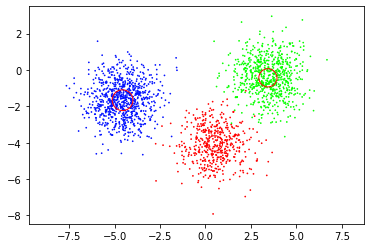

In [11]:
@config_enumerate
def GMM(data=None,N=100,K=2,D=2):
    weights = pyro.sample('weights', dist.Dirichlet(10 * torch.ones(K)))
    with pyro.plate('components', K):
        locs = pyro.sample('locs', dist.MultivariateNormal(torch.zeros(D),20*torch.eye(D)))

    with pyro.plate('data', N):
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        obs = pyro.sample('obs', dist.MultivariateNormal(locs[assignment,:], 1*torch.eye(D)), obs=data)
    
    return weights,locs,assignment,obs


K = 3
D = 5
N = 2000
pi,mu,z,data = GMM(N=N,K=K,D=D)

V.plot_gmm_2d(data,mu,pi,z)

In [12]:
pyro.set_rng_seed(0)
pyro.clear_param_store()

guide = AutoDelta(poutine.block(GMM, expose=['weights', 'locs']))
optim = pyro.optim.Adam({'lr': 1.0})

elbo = TraceEnum_ELBO(max_plate_nesting=1)
pyro.param('AutoDelta.weights', torch.ones(K)/K, constraint=constraints.simplex)

# elbo.loss(GMM, config_enumerate(guide, "parallel"))

svi = SVI(GMM, guide, optim, loss=elbo)

elbo = TraceTMC_ELBO(max_plate_nesting=2)
tmc_model = poutine.infer_config(GMM,
    lambda msg: {"num_samples": 10, "expand": False} if msg["infer"].get("enumerate", None) == "parallel" else {},
)
svi = SVI(tmc_model, guide, optim, elbo)


gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []


In [13]:
for i in range(30):
    loss = svi.step(data,N=len(data),K=K,D=D)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')



.............................

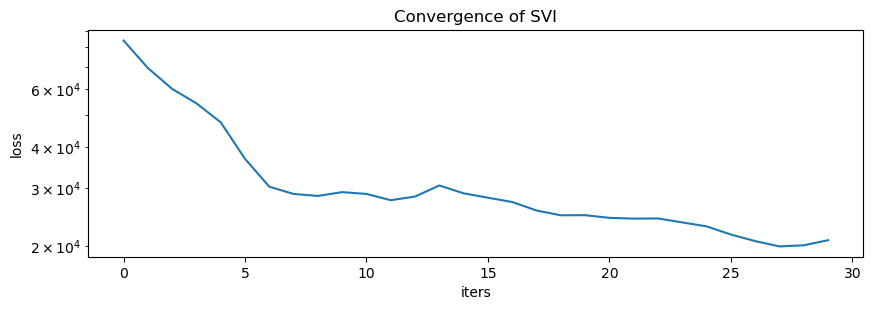

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


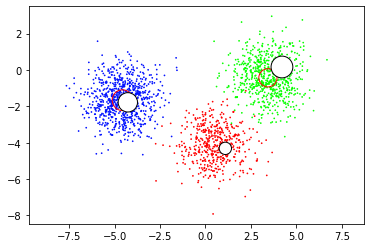

In [17]:
V.plot_loss(losses)

map_estimates = guide(data)
weights = map_estimates['weights'].data.numpy()
locs = map_estimates['locs'].data.numpy()

V.plot_gmm_2d(data,mu,pi,z,weights,locs)